<a href="https://colab.research.google.com/github/shashank237/CyberBullying-Detection-using-ML/blob/main/TwitterBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! python --version

Python 3.7.10


# Installing Necesary Libraries

In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

     |████████████████████████████████| 1.6MB 14.5MB/s 
     |████████████████████████████████| 38.2MB 81kB/s 
     |████████████████████████████████| 686kB 29.4MB/s 
     |████████████████████████████████| 1.2MB 40.4MB/s 
     |████████████████████████████████| 358kB 50.2MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 174kB 57.4MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-cp37-none-any.whl size=22245 sha256=848b79478c6f2b3c8b3b0a0fcb6fd69f2d2678c8cee22117eb227d8a22db9e90
  Stored in directory: /root/.cache/pip/wheels/2e/15/f5/aa2a056d223903b52cf4870134e3a01df0c723816835dd08db
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=0f92aa7ea334b3483074f0490ee9548bd3b93cf8139bb4a6a60122b621cd28b1
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704

In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


#Loading the Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cleanTarget.csv to cleanTarget.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['cleanTarget.csv']))

In [ ]:
df.head()

,Tweet,Class,Target
0,.omg why are poc wearing fugly blue contacts s...,Non-Bullying,1
1,.Sorry but most of the runners popular right n...,Non-Bullying,1
2,".those jeans are hideous, and I?m afraid he?s ...",Non-Bullying,1
3,.I had to dress up for a presentation in class...,Non-Bullying,1
4,.Am I the only one who thinks justin bieber is...,Non-Bullying,1


In [ ]:
df.Target.unique()

array([1, 0])

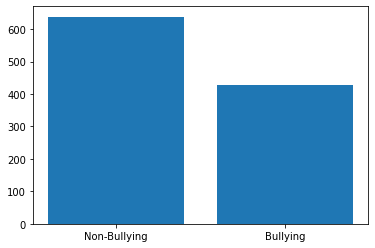

In [ ]:
classes = df.Target.unique()
counts = []

for i in classes:
  count = len(df[df.Target==i])
  counts.append(count)

plt.bar(['Non-Bullying', 'Bullying'], counts)
plt.show()

#Train/test split

In [ ]:
sample_size = int(len(df))
sampleDf = df.sample(sample_size, random_state=23)
x = sampleDf.Tweet.values
y = sampleDf.Target.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

#Label Encoding


In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

We might want to use encoding for later. For that we can save enconding map.

In [ ]:
encoder_fname = 'twitter_classes.npy'
my_wd = '/content/drive/MyDrive/twitter_sentiment_course/'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

# Tokenization
To tokenize our text we will use some functions from official.nlp.bert package and the pretrained BERT model itself.

*   First we will get the BERT model.
*   We will use the multilingual one as it will be best for most of your cases.



In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

We have loaded some variables using the bert_layer we have downloaded.

* **vocab_file** reads the vocab file associated to the downloaded model.

* **do_lower_case** reads binary variable which if True means tokenizer will reformat all text to lower case rendering model to be NOT case sensitive. Should be False by default.

* **tokenizer** builds tokenizer using variables 1 and 2.

In [ ]:
do_lower_case

False

We need to add two additional tokens: Classification and Seperation. We will add these through functions we will use to tokenize our text.

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Now we perform tokenization on the data

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would be much more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized Tweets shape', tweets.shape.as_list())

Tokenized Tweets shape [852, None]


This is what our tweets have converted to.

In [ ]:
tweets[0]

<tf.Tensor: shape=(41,), dtype=int32, numpy=
array([20386, 70197, 10129, 22153, 11178, 10464, 10479, 34481, 10171,
       10105, 10751,   108, 14873, 41665, 11274, 10354, 10129, 11897,
       10124,   169, 25831,   119,   119,   112,   117,   112, 17144,
       10107, 47271, 11369, 18090, 30668, 20386, 10105, 14249, 25831,
       20194, 92113, 80674,   119,   102], dtype=int32)>

This is how tokenizer does the "tokenizing" for a single tweet.

In [ ]:
x_train[0]

"Rob Reiner says any one who watches the new #RoseanneBarr show is a Nazi ..', 'Lets ALL give ol Rob the anti Nazi patriot salut."

In [ ]:

tokenizedTweet = tokenizer.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizer.convert_tokens_to_ids([i]))

Rob [20386]
Reine [70197]
##r [10129]
says [22153]
any [11178]
one [10464]
who [10479]
watch [34481]
##es [10171]
the [10105]
new [10751]
# [108]
Rose [14873]
##anne [41665]
##B [11274]
##ar [10354]
##r [10129]
show [11897]
is [10124]
a [169]
Nazi [25831]
. [119]
. [119]
' [112]
, [117]
' [112]
Let [17144]
##s [10107]
AL [47271]
##L [11369]
give [18090]
ol [30668]
Rob [20386]
the [10105]
anti [14249]
Nazi [25831]
pat [20194]
##riot [92113]
salut [80674]
. [119]


We still need to add classification token.

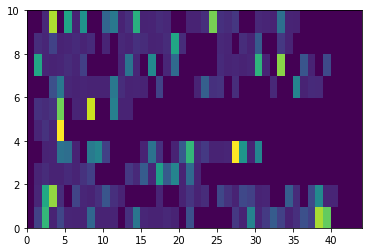

In [ ]:

cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())


What you see above is a graphical representation of our tokenized tweets.
* First token is our classification token.
* Other colored blocks than background are other tokens.
* And background that's just padding.

**Mask and input type**
The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding.

In [ ]:
input_word_ids

<tf.RaggedTensor [[101, 20386, 70197, 10129, 22153, 11178, 10464, 10479, 34481, 10171, 10105, 10751, 108, 14873, 41665, 11274, 10354, 10129, 11897, 10124, 169, 25831, 119, 119, 112, 117, 112, 17144, 10107, 47271, 11369, 18090, 30668, 20386, 10105, 14249, 25831, 20194, 92113, 80674, 119, 102], [101, 11590, 63815, 88998, 13028, 171, 21511, 11195, 10124, 14444, 28088, 14336, 10350, 106, 112, 117, 107, 10377, 112, 187, 10146, 16065, 10146, 13028, 112, 22469, 15329, 10114, 22899, 20637, 10169, 10911, 136, 136, 30929, 12926, 131, 23267, 50292, 10797, 10874, 107, 166, 102], [101, 10772, 13028, 10301, 10105, 12541, 10550, 15127, 20104, 119, 112, 117, 112, 17116, 12373, 30455, 11315, 60036, 29846, 47798, 10123, 36110, 10689, 119, 102], [101, 119, 10117, 10751, 40162, 37830, 10124, 169, 43477, 48201, 20085, 119, 112, 117, 112, 10287, 40162, 14819, 136, 10323, 30181, 70157, 12676, 17427, 10108, 10105, 11005, 106140, 55291, 10107, 48628, 119, 102], [101, 11065, 15198, 11005, 106140, 119, 102], [10

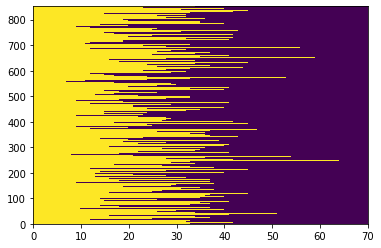

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

Here each yellow block has some input. We just make this for the model to differ between padding and input.

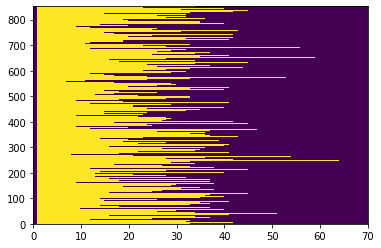

In [ ]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tweets)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)


It's hard to see but we added an empty block in front of each tweet for the [CLS] token. Check tensor below

In [ ]:
input_type_ids

<tf.Tensor: shape=(852, 70), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

Remake into a function for normal use
So at this point we have all of our three inputs:

* Tokens

* Input mask

* Input type


In [ ]:
lens = [len(i) for i in input_word_ids]

In [ ]:

max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 70


In [ ]:
max_seq_length = int(1.5*max_seq_length)
print('Max length is:', max_seq_length)

Max length is: 105


# Creating Functions

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)

  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

#Processing Inputs

In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

#Modelling

**Initial training**

We need to set up our model using the inputs we made, BERT model that we downloaded and an output layer based on num of classes we are using.

In [ ]:
num_class = len(encoder.classes_)
max_seq_length = max_seq_length


input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

**Model Architecture**

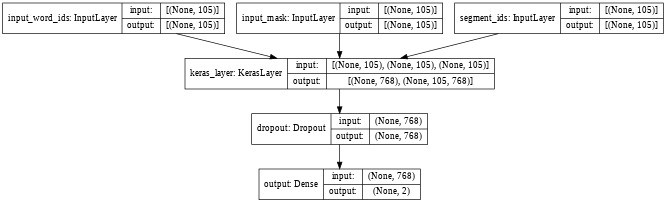

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

**Set up the training parameters.**

In [ ]:
epochs = 3
batch_size = 16
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

# Compile the model.

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 105)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 105)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 105)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

Set up a history to check our model performance afterwards.

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
54/54 [==============================] - 41s 466ms/step - loss: 0.6402 - accuracy: 0.6408 - val_loss: 0.6038 - val_accuracy: 0.7089
Epoch 2/3
54/54 [==============================] - 24s 447ms/step - loss: 0.4688 - accuracy: 0.7946 - val_loss: 0.6209 - val_accuracy: 0.7042
Epoch 3/3
54/54 [==============================] - 24s 444ms/step - loss: 0.3325 - accuracy: 0.8674 - val_loss: 0.6666 - val_accuracy: 0.7089



# Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9190
Testing Accuracy:  0.7089


# Plotting graphs

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

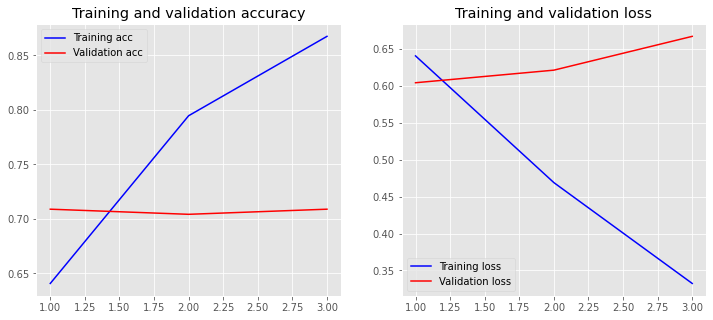

In [ ]:
plot_history(history)


# Model saving for later use

Let's saving  our model for later use.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/drive/MyDrive/twitter_sentiment_course/'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/twitter_sentiment_course/twitter_BERT/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/twitter_sentiment_course/twitter_BERT/assets


**Validate saved model**

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/drive/MyDrive/twitter_sentiment_course/'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7089


# **Test**

We need to check in with our label encoder to get our classes.

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/drive/MyDrive/twitter_sentiment_course/'

tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
encoder_fname = 'twitter_classes.npy'
my_wd = '/content/drive/MyDrive/twitter_sentiment_course/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

This is how our classes are encoded for the model.

In [ ]:
encoder.classes_

array([0, 1])

Input preprocessing.

In [ ]:
tweet = ['And why do you care what I say???, Lol looks like you have a crush you creepy Fag.']
inputs = bert_encode(string_list=list(tweet),
                     tokenizer=tokenizerSaved,
                     max_seq_length=105)

Prediction


In [ ]:
prediction = new_model.predict(inputs)
print(prediction)
print('Tweet is', 'Non-Bullying' if encoder.classes_[np.argmax(prediction)]==1 else 'Bullying')

In [ ]:
inputs

In [ ]:
tweet = ['I had to dress up for a presentation in class today and I?m giving some serious Mr. Grey zaddy vibes if I do say so myself']
inputs = bert_encode(string_list=list(tweet),
                     tokenizer=tokenizerSaved,
                     max_seq_length=105)

In [ ]:
prediction = new_model.predict(inputs)
print(prediction)
print('Tweet is', 'Non-Bullying' if encoder.classes_[np.argmax(prediction)]==1 else 'Bullying')

# Evaluation

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(encoder.classes_[np.argmax(dummy_y_test,axis=1)],encoder.classes_[np.argmax(test_predict,axis=1)]))

              precision    recall  f1-score   support

           0       0.65      0.57      0.61        84
           1       0.74      0.80      0.77       129

    accuracy                           0.71       213
   macro avg       0.69      0.68      0.69       213
weighted avg       0.70      0.71      0.71       213



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(encoder.classes_[np.argmax(dummy_y_test,axis=1)],encoder.classes_[np.argmax(test_predict,axis=1)]))

[[ 48  36]
 [ 26 103]]


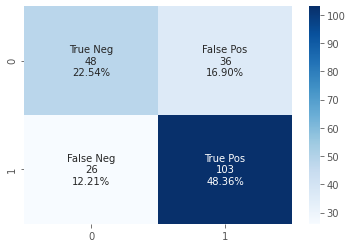

In [ ]:
cm = confusion_matrix(encoder.classes_[np.argmax(dummy_y_test,axis=1)],encoder.classes_[np.argmax(test_predict,axis=1)])
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')